# Representation Learning For Gait Analysis in Parkinson’s Patients
- Dataset of 290 participants
- every participant did a 4 x 10 m walking test
    - participants with Parkinson disease have a label of Hoehn and Yahr and UPDRS
- Your task:
    - develop a neural network e.g. Convolutional, LSTM etc.
    - use an autoencoder and try to classify the healthy and sick participants
        - train on healthy 
        - analyse reconstruction error for sick vs healthy 
        - maybe take latent representation of autoencoder and try to classify
        - 1d convolution autoencoder
    - map to healthy and sick 
    - map to UPDRS score(?)



In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import os

In [74]:
data_path = Path('../data/raw_data')
participant_labels = pd.read_csv(data_path.joinpath('Labels.csv'))
participant_labels.head()

,STUD_Ganganalyse,Alter_bei_Studie,Geschlecht,Groesse_cm,Groesse_m,Gewicht_kg,BMI,Hoehn_Yahr,UPDRS_Motor_Scale
0,GA111039,36,2,167,1.67,62.0,22.230987,1.0,7.0
1,GA112017,37,1,170,1.70,125.0,43.252595,2.0,30.0
2,GA114057,38,1,163,1.63,70.0,26.346494,2.0,15.0
3,GA412024,39,2,160,1.60,56.0,21.875000,1.0,7.0
4,GA310004,40,2,165,1.65,70.0,25.711662,3.0,25.0


In [75]:
example = next(data_path.iterdir())
sensor_data = list(example.glob('*.csv'))
#sensor_left.filter(like="acc_").plot()

In [76]:
participant_labels['labels'] = 0

participant_labels['Hoehn_Yahr'] = participant_labels['Hoehn_Yahr'].replace(np.nan, 0.0)
participant_labels['UPDRS_Motor_Scale'] = participant_labels['UPDRS_Motor_Scale'].replace(np.nan, 0.0)

participant_labels.loc[(participant_labels['Hoehn_Yahr'] > 0.0) & (participant_labels['UPDRS_Motor_Scale'] > 0.0), "labels"] = 1

In [77]:
participant_labels['Alter_bei_Studie_cut'] = pd.cut(x=participant_labels['Alter_bei_Studie'], 
                                                    bins=[30, 39, 49, 59, 69, 79, 89], 
                                                    labels=['30s', '40s', '50s', '60s', '70s', '80s'])

participant_labels['Geschlecht'].replace({1: "Male", 2: "Female"}, inplace=True)

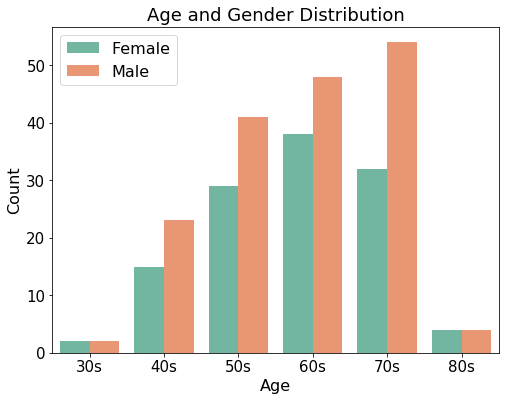

In [118]:
plt.figure(figsize=(8,6))
plt.title("Age and Gender Distribution", fontsize=18)
ax = sns.countplot(x="Alter_bei_Studie_cut", data=participant_labels, hue="Geschlecht", palette="Set2")
ax.set_xlabel("Age", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(participant_labels['STUD_Ganganalyse'],
                 participant_labels["labels"],
                 stratify=participant_labels[["labels", "Geschlecht"]],
                 test_size=0.2)

assert ((y_train == 1).sum() / len(y_train)) - ((y_test == 1).sum() / len(y_test)) < 0.1

In [11]:
train_df = pd.DataFrame()

missing = 0
count = 0

for i, user in enumerate(X_train):
    left_path = os.path.join(data_path, user, "sensor_data_left.csv")
    right_path = os.path.join(data_path, user, "sensor_data_right.csv")
        
    try:
        df_l = pd.read_csv(left_path).add_prefix("left_").drop(columns=["left_Unnamed: 0"])
        df_r = pd.read_csv(left_path).add_prefix("right_").drop(columns=["right_Unnamed: 0"])
    except:
        missing += 1
        print("Missing CSV")
    
    if len(df_r) != len(df_l):
        missing += 1
        print("Not the same length")
        
    else:
        df_user = pd.concat([df_l, df_r], axis=1)
        df_user['user_id'] = i
        df_user['patient_id'] = user
        df_user['patient_nr'] = count
        train_df = train_df.append(df_user, ignore_index=True)
        count += 1
    
print(f"{missing} Users")

Missing CSV
Missing CSV
2 Users


In [12]:
test_df = pd.DataFrame()

missing = 0

for i, user in enumerate(X_test):
    left_path = os.path.join(data_path, user, "sensor_data_left.csv")
    right_path = os.path.join(data_path, user, "sensor_data_right.csv")
        
    try:
        df_l = pd.read_csv(left_path).add_prefix("left_").drop(columns=["left_Unnamed: 0"])
        df_r = pd.read_csv(left_path).add_prefix("right_").drop(columns=["right_Unnamed: 0"])
    except:
        try:
            df_l = pd.read_csv(left_path).add_prefix("left_")
            df_r = pd.read_csv(left_path).add_prefix("right_")
        except:
            missing += 1
            print("Missing CSV")
    
    if len(df_r) != len(df_l):
        missing += 1
        print("Not the same length")
        
    else:
        df_user = pd.concat([df_l, df_r], axis=1)
        df_user['user_id'] = i
        df_user['patient_id'] = user
        df_user['patient_nr'] = count
        test_df = test_df.append(df_user, ignore_index=True)
        count += 1
    
print(f"{missing} Users")

0 Users


In [13]:
y_train = y_train.reset_index().drop(columns="index")
y_test = y_test.reset_index().drop(columns="index")

train_df['labels'] = train_df['user_id'].apply(lambda x: y_train.iloc[x]['labels'])
test_df['labels'] = test_df['user_id'].apply(lambda x: y_test.iloc[x]['labels'])

In [14]:
print(f"Train_df: {train_df.shape}")
print(f"Test_df: {test_df.shape}")

Train_df: (1036564, 16)
Test_df: (286899, 16)


In [15]:
train_df.to_csv("train.csv")
test_df.to_csv("test.csv")
print("Successfully saved.")

Successfully saved.


No handles with labels found to put in legend.


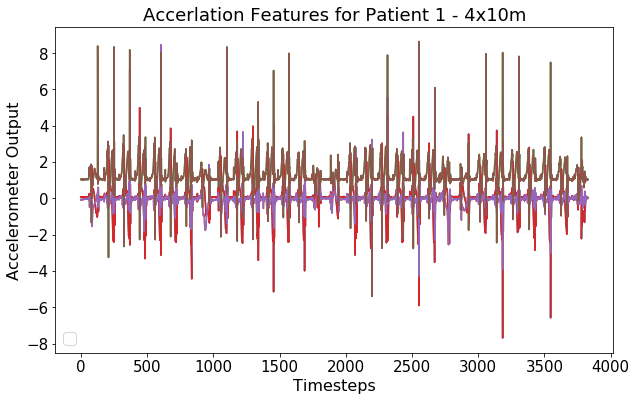

In [114]:
plt.figure(figsize=(10,6))
X = train_df[train_df["user_id"] == 0].filter(like="acc_")
plt.plot(X)
plt.title("Accerlation Features for Patient 1 - 4x10m", fontsize=18)
plt.xlabel("Timesteps", fontsize=16)
plt.ylabel("Accelerometer Output", fontsize=16)
plt.legend(loc="lower left", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [116]:
X = pd.concat([train_df, test_df]).groupby(["patient_nr"]).count()["left_acc_x"]

No handles with labels found to put in legend.


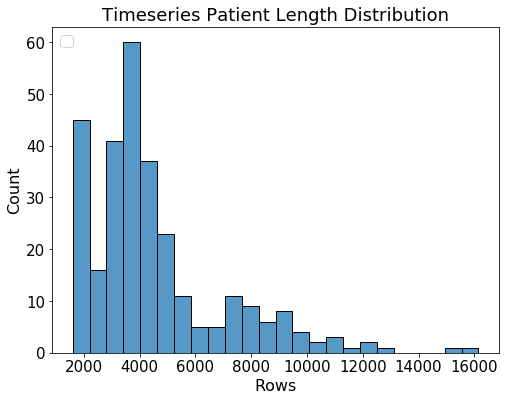

In [117]:
plt.figure(figsize=(8,6))
plt.title("Timeseries Patient Length Distribution", fontsize=18)
ax = sns.histplot(X, palette="Set2")
ax.set_xlabel("Rows", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Planning and Execution:
- use the provided git template to store and work on everything
- make helpful comments so it is comprehensable why you made that decision 
- use git features like branches issue boards etc. to keep the overview over the current progress

## Data Exploration, Training and more:
- decide on the input factors 
- think about splitting the data into training and test sets
- check if you work with an unbalanced data set
- fit the data of each sensor such that the data length is equal 
- number of features in [autoencoder](https://towardsdatascience.com/generating-images-with-autoencoders-77fd3a8dd368)
- [recipe for network training](http://karpathy.github.io/2019/04/25/recipe/)
- think about masking 
- test different model configurations
- decide what timeframe to use as input for each cell if recurrent network


## Presentation of the Results:
- short scientific report or a well maintained git repository with an explanatory jupyter notebook 
- in both cases: 
    - well designed visualisations with easy to understand labels
    - comments in code that explain the decision making process for hyperparameters or batch sizes

## Usage of RRZE accounts:
- activate HPC in idm Portal
- talk to other students 
- send GitHub introduction
- invite to student slack

## Division of Tasks:
- how you split the workload is on you in the end both problems should be solved and documented



# EDA

In [47]:
map_train_df = train_df[["patient_nr", "patient_id"]].drop_duplicates()
map_test_df = test_df[["patient_nr", "patient_id"]].drop_duplicates()

agg_map_df = pd.merge(agg_df, map_train_df, left_on="STUD_Ganganalyse", right_on="patient_id", how="left")
agg_map_df = pd.merge(agg_map_df, map_test_df, left_on="STUD_Ganganalyse", right_on="patient_id", how="left")

agg_map_df["user_id"] = (agg_map_df["patient_nr_x"].replace(np.nan, 0) + agg_map_df["patient_nr_y"].replace(np.nan, 0)).astype(int)

agg_map_df = agg_map_df.drop(columns=["patient_id_x", "patient_nr_y", "patient_id_y", "patient_nr_x"])

In [48]:
meta_train_df = pd.DataFrame(train_df.groupby("user_id").count()['labels'].sort_values(ascending=False)).reset_index()
meta_train_df['user_id'] = meta_train_df['user_id'].astype(str)

meta_test_df = pd.DataFrame(test_df.groupby("user_id").count()['labels'].sort_values(ascending=False)).reset_index()
meta_test_df['user_id'] = meta_test_df['user_id'].astype(int)

In [49]:
meta_df = pd.concat([meta_train_df, meta_test_df], axis=0)
meta_df["user_id"] = meta_df["user_id"].astype(int)

In [50]:
batch_size = 256

meta_df['batches'] = meta_df['labels'].apply(lambda x: int(int(x) / batch_size))

In [52]:
merged_df = pd.merge(meta_df, agg_map_df, on="user_id").drop_duplicates()

In [398]:
merged_df['age_bins'] = pd.cut(x=merged_df['Alter_bei_Studie'], bins=[30, 40, 50, 60, 70, 80, 90])
merged_df['m_bins'] = pd.cut(x=merged_df['Groesse_cm'], bins=[140, 150, 160, 170, 180, 190, 200])

In [399]:
train_labels = train_df[["patient_id", "labels"]].drop_duplicates()
test_labels = test_df[["patient_id", "labels"]].drop_duplicates()

df_labels = pd.DataFrame(columns=["user_id", "y"], data=np.concatenate([train_labels, test_labels], axis=0))
#df_labels = df_labels['user_id'].astype(int)

In [400]:
merged_df = pd.merge(merged_df, df_labels, left_on="STUD_Ganganalyse", right_on="user_id")
merged_df = merged_df.drop(columns=["user_id_x", "user_id_y", "user_id_y"])

## Alters Vergleich

> Starke Korrelation zwischen älter sein und mehr Einträge haben

In [402]:
merged_df.groupby(["age_bins", "y"]).mean()[]

labels    batches  Alter_bei_Studie  Groesse_cm  Geschlecht
age_bins y                                                                   
(30, 40] 0           NaN        NaN               NaN         NaN         NaN
         1   4336.833333  16.333333         37.833333  164.166667    1.666667
(40, 50] 0   3768.761905  14.333333         45.714286  176.047619    1.428571
         1   4227.391304  16.086957         46.086957  179.173913    1.173913
(50, 60] 0   3857.607143  14.678571         55.678571  169.321429    1.607143
         1   4408.227273  16.750000         56.000000  174.159091    1.295455
(60, 70] 0   4555.576923  17.269231         66.807692  167.692308    1.576923
         1   4534.684211  17.157895         66.263158  171.596491    1.350877
(70, 80] 0   4708.952381  17.857143         73.142857  169.904762    1.476190
         1   4764.135593  18.169492         74.271186  170.322034    1.322034
(80, 90] 0   6499.000000  25.000000         82.750000  162.000000    1.500000
         1  10295.333333  39.666667         82.333333  173.666667    1.000000

## Körpergrößen Vergleich

> Ziemlich Zufällig

In [403]:
merged_df.groupby(["m_bins", "y"]).mean()

labels    batches  Alter_bei_Studie  Groesse_cm  Geschlecht
m_bins     y                                                                  
(140, 150] 0          NaN        NaN               NaN         NaN         NaN
           1  2372.500000   9.000000         69.500000  150.000000    2.000000
(150, 160] 0  5350.333333  20.333333         63.933333  158.266667    2.000000
           1  5696.250000  21.687500         68.500000  158.250000    1.937500
(160, 170] 0  4253.000000  16.175000         63.350000  166.400000    1.825000
           1  4401.736111  16.750000         63.083333  167.097222    1.472222
(170, 180] 0  4109.810811  15.648649         60.135135  175.918919    1.135135
           1  4679.757143  17.814286         65.142857  176.285714    1.128571
(180, 190] 0  3506.000000  13.125000         50.625000  184.375000    1.000000
           1  4463.964286  16.821429         58.214286  183.571429    1.000000
(190, 200] 0          NaN        NaN               NaN         NaN         NaN
           1  5569.000000  21.250000         47.500000  194.250000    1.000000

## Geschlechter Vergleich

> Keine Korrelation

In [410]:
merged_df.groupby(["Geschlecht", "y"]).mean()

labels    batches  Alter_bei_Studie  Groesse_cm
Geschlecht y                                                      
1          0  4114.680851  15.595745         61.319149  176.085106
           1  4626.575758  17.583333         63.356061  175.992424
2          0  4473.509434  17.037736         61.150943  164.867925
           1  4615.866667  17.550000         63.233333  164.816667